# 株価予測(分類予測)

## 目的  
#### LSTMを用いて、「前日までのデータを元に、翌日の終値が上がるか下がるかの予測モデル」を作成する

## 検証①

データの読み込み、整形

In [1]:
# ライブラリのインポート
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#warningを非表示化
import warnings
warnings.simplefilter('ignore')

In [3]:
# pandas_datareaderを使って、2018年始から2021年末までの日経平均株価データの取得
start = '2018-01-01'
end = '2021-12-31'
df = data.DataReader('^N225', 'yahoo', start, end)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-04,23506.330078,23065.199219,23073.730469,23506.330078,102200000.0,23506.330078
2018-01-05,23730.470703,23520.519531,23643.000000,23714.529297,101900000.0,23714.529297
2018-01-09,23952.609375,23789.029297,23948.970703,23849.990234,94100000.0,23849.990234
2018-01-10,23864.759766,23755.449219,23832.810547,23788.199219,88800000.0,23788.199219
2018-01-11,23734.970703,23601.839844,23656.390625,23710.429688,83700000.0,23710.429688
...,...,...,...,...,...,...
2021-12-24,28870.130859,28773.500000,28836.050781,28782.589844,35900000.0,28782.589844
2021-12-27,28805.279297,28658.820312,28786.330078,28676.460938,37500000.0,28676.460938
2021-12-28,29121.009766,28879.679688,28953.320312,29069.160156,47000000.0,29069.160156


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 974 entries, 2018-01-04 to 2021-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       974 non-null    float64
 1   Low        974 non-null    float64
 2   Open       974 non-null    float64
 3   Close      974 non-null    float64
 4   Volume     974 non-null    float64
 5   Adj Close  974 non-null    float64
dtypes: float64(6)
memory usage: 53.3 KB


In [5]:
from datetime import datetime
from datetime import timedelta

#基準となる日の2018年1月4日の値を変数startに代入する。
start = datetime(2018,1,4)
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-04,23506.330078,23065.199219,23073.730469,23506.330078,102200000.0,23506.330078
2018-01-05,23730.470703,23520.519531,23643.000000,23714.529297,101900000.0,23714.529297
2018-01-09,23952.609375,23789.029297,23948.970703,23849.990234,94100000.0,23849.990234
2018-01-10,23864.759766,23755.449219,23832.810547,23788.199219,88800000.0,23788.199219
2018-01-11,23734.970703,23601.839844,23656.390625,23710.429688,83700000.0,23710.429688


### 目的変数の追加

In [6]:
#カラム情報を1日分ずらしたデータフレームを作成する
df_shift_1day=df.shift(-1)
df_shift_1day.tail(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2021-12-17,28441.509766,27893.179688,28325.460938,27937.810547,65200000.0,27937.810547
2021-12-20,28533.740234,28226.429688,28309.599609,28517.589844,55800000.0,28517.589844
2021-12-21,28673.769531,28473.849609,28614.060547,28562.210938,44700000.0,28562.210938
2021-12-22,28798.369141,28640.150391,28703.009766,28798.369141,43600000.0,28798.369141
2021-12-23,28870.130859,28773.500000,28836.050781,28782.589844,35900000.0,28782.589844
2021-12-24,28805.279297,28658.820312,28786.330078,28676.460938,37500000.0,28676.460938
2021-12-27,29121.009766,28879.679688,28953.320312,29069.160156,47000000.0,29069.160156
2021-12-28,29106.279297,28729.609375,28995.730469,28906.880859,44700000.0,28906.880859
2021-12-29,28904.419922,28579.490234,28794.240234,28791.710938,40400000.0,28791.710938


In [7]:
#次の日の始値と本日の終値の差分を追加する
df['delta_Close']=df_shift_1day['Close']-df['Close']
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,delta_Close
Date,,,,,,,
2021-12-17,28904.939453,28503.080078,28854.599609,28545.679688,84400000.0,28545.679688,-607.869141
2021-12-20,28441.509766,27893.179688,28325.460938,27937.810547,65200000.0,27937.810547,579.779297
2021-12-21,28533.740234,28226.429688,28309.599609,28517.589844,55800000.0,28517.589844,44.621094
2021-12-22,28673.769531,28473.849609,28614.060547,28562.210938,44700000.0,28562.210938,236.158203
2021-12-23,28798.369141,28640.150391,28703.009766,28798.369141,43600000.0,28798.369141,-15.779297
2021-12-24,28870.130859,28773.500000,28836.050781,28782.589844,35900000.0,28782.589844,-106.128906
2021-12-27,28805.279297,28658.820312,28786.330078,28676.460938,37500000.0,28676.460938,392.699219
2021-12-28,29121.009766,28879.679688,28953.320312,29069.160156,47000000.0,29069.160156,-162.279297
2021-12-29,29106.279297,28729.609375,28995.730469,28906.880859,44700000.0,28906.880859,-115.169922


In [8]:
#目的変数Upを追加する(次の日の終値が上がる場合1、それ以外は0とする)
df['Up']=0
df['Up'][df['delta_Close']>0]=1

#'delta_Close'カラムの削除
df=df.drop('delta_Close',axis=1)
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,Up
Date,,,,,,,
2021-12-17,28904.939453,28503.080078,28854.599609,28545.679688,84400000.0,28545.679688,0
2021-12-20,28441.509766,27893.179688,28325.460938,27937.810547,65200000.0,27937.810547,1
2021-12-21,28533.740234,28226.429688,28309.599609,28517.589844,55800000.0,28517.589844,1
2021-12-22,28673.769531,28473.849609,28614.060547,28562.210938,44700000.0,28562.210938,1
2021-12-23,28798.369141,28640.150391,28703.009766,28798.369141,43600000.0,28798.369141,0
2021-12-24,28870.130859,28773.500000,28836.050781,28782.589844,35900000.0,28782.589844,0
2021-12-27,28805.279297,28658.820312,28786.330078,28676.460938,37500000.0,28676.460938,1
2021-12-28,29121.009766,28879.679688,28953.320312,29069.160156,47000000.0,29069.160156,0
2021-12-29,29106.279297,28729.609375,28995.730469,28906.880859,44700000.0,28906.880859,0


## データの全体像を掴む

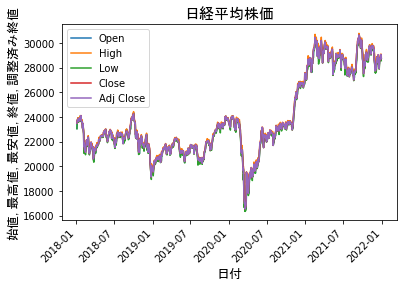

In [9]:
# 'Open', 'High', 'Low', 'Close'グラフ化のためにカラム抽出
df_new = df[['Open', 'High', 'Low', 'Close','Adj Close']]

# matplotlibのインポート
from matplotlib import pyplot as plt

# 時系列折れ線グラフの作成
df_new.plot(kind='line')

#タイトル等をラベル表示
plt.title('日経平均株価', fontsize = 15,fontname="MS Gothic")
plt.xlabel('日付', fontsize = 13,fontname="MS Gothic")
plt.ylabel('始値,最高値,最安値,終値,調整済み終値', fontsize = 13,fontname="MS Gothic")

#x軸ラベルを45°回転
plt.xticks(rotation=45)

# グラフの表示
plt.show()

## 特徴量の追加  
*  終値の前日比率  
*  始値・終値の差分

In [10]:
# 終値の次の日との比の追加
df['Close_ratio']=(df['Close']-df_shift_1day['Close'])/df_shift_1day['Close']
df.tail()

,High,Low,Open,Close,Volume,Adj Close,Up,Close_ratio
Date,,,,,,,,
2021-12-24,28870.130859,28773.500000,28836.050781,28782.589844,35900000.0,28782.589844,0,0.003701
2021-12-27,28805.279297,28658.820312,28786.330078,28676.460938,37500000.0,28676.460938,1,-0.013509
2021-12-28,29121.009766,28879.679688,28953.320312,29069.160156,47000000.0,29069.160156,0,0.005614
2021-12-29,29106.279297,28729.609375,28995.730469,28906.880859,44700000.0,28906.880859,0,0.004000
2021-12-30,28904.419922,28579.490234,28794.240234,28791.710938,40400000.0,28791.710938,0,NaN


In [11]:
#始値と終値の差分を追加。
df['Body']=df['Open']-df['Close']
df.tail()

,High,Low,Open,Close,Volume,Adj Close,Up,Close_ratio,Body
Date,,,,,,,,,
2021-12-24,28870.130859,28773.500000,28836.050781,28782.589844,35900000.0,28782.589844,0,0.003701,53.460938
2021-12-27,28805.279297,28658.820312,28786.330078,28676.460938,37500000.0,28676.460938,1,-0.013509,109.869141
2021-12-28,29121.009766,28879.679688,28953.320312,29069.160156,47000000.0,29069.160156,0,0.005614,-115.839844
2021-12-29,29106.279297,28729.609375,28995.730469,28906.880859,44700000.0,28906.880859,0,0.004000,88.849609
2021-12-30,28904.419922,28579.490234,28794.240234,28791.710938,40400000.0,28791.710938,0,NaN,2.529297


In [12]:
# カラムの並べ替え
df = df[[ 'High', 'Low', 'Open', 'Close','Volume','Adj Close','Close_ratio', 'Body', 'Up']]
df

,High,Low,Open,Close,Volume,Adj Close,Close_ratio,Body,Up
Date,,,,,,,,,
2018-01-04,23506.330078,23065.199219,23073.730469,23506.330078,102200000.0,23506.330078,-0.008779,-432.599609,1
2018-01-05,23730.470703,23520.519531,23643.000000,23714.529297,101900000.0,23714.529297,-0.005680,-71.529297,1
2018-01-09,23952.609375,23789.029297,23948.970703,23849.990234,94100000.0,23849.990234,0.002598,98.980469,0
2018-01-10,23864.759766,23755.449219,23832.810547,23788.199219,88800000.0,23788.199219,0.003280,44.611328,0
2018-01-11,23734.970703,23601.839844,23656.390625,23710.429688,83700000.0,23710.429688,0.002393,-54.039062,0
...,...,...,...,...,...,...,...,...,...
2021-12-24,28870.130859,28773.500000,28836.050781,28782.589844,35900000.0,28782.589844,0.003701,53.460938,0
2021-12-27,28805.279297,28658.820312,28786.330078,28676.460938,37500000.0,28676.460938,-0.013509,109.869141,1
2021-12-28,29121.009766,28879.679688,28953.320312,29069.160156,47000000.0,29069.160156,0.005614,-115.839844,0


### 学習データと検証データに分割

In [13]:
# 学習データを2018-01-04〜2020-12-31の期間としdf_trainに入力する
df_train=df['2018-01-04':'2020-12-31']
df_train.head()

,High,Low,Open,Close,Volume,Adj Close,Close_ratio,Body,Up
Date,,,,,,,,,
2018-01-04,23506.330078,23065.199219,23073.730469,23506.330078,102200000.0,23506.330078,-0.008779,-432.599609,1
2018-01-05,23730.470703,23520.519531,23643.000000,23714.529297,101900000.0,23714.529297,-0.005680,-71.529297,1
2018-01-09,23952.609375,23789.029297,23948.970703,23849.990234,94100000.0,23849.990234,0.002598,98.980469,0
2018-01-10,23864.759766,23755.449219,23832.810547,23788.199219,88800000.0,23788.199219,0.003280,44.611328,0
2018-01-11,23734.970703,23601.839844,23656.390625,23710.429688,83700000.0,23710.429688,0.002393,-54.039062,0


In [14]:
# 検証データを2021-01-01以降としてとしてdf_valに入力する
df_val=df['2021-01-01':]
df_val.tail()

,High,Low,Open,Close,Volume,Adj Close,Close_ratio,Body,Up
Date,,,,,,,,,
2021-12-24,28870.130859,28773.500000,28836.050781,28782.589844,35900000.0,28782.589844,0.003701,53.460938,0
2021-12-27,28805.279297,28658.820312,28786.330078,28676.460938,37500000.0,28676.460938,-0.013509,109.869141,1
2021-12-28,29121.009766,28879.679688,28953.320312,29069.160156,47000000.0,29069.160156,0.005614,-115.839844,0
2021-12-29,29106.279297,28729.609375,28995.730469,28906.880859,44700000.0,28906.880859,0.004000,88.849609,0
2021-12-30,28904.419922,28579.490234,28794.240234,28791.710938,40400000.0,28791.710938,NaN,2.529297,0


In [15]:
xdays = 7

# 学習データを説明変数(X_train)と目的変数(y_train)に分ける
x_train=df_train[['High', 'Low', 'Open', 'Close','Volume','Adj Close','Close_ratio', 'Body']]
y_train=df_train['Up'][xdays:]

# 学習データの説明変数と目的変数を確認
print(x_train)
print(y_train)

                    High           Low          Open         Close  \
Date                                                                 
2018-01-04  23506.330078  23065.199219  23073.730469  23506.330078   
2018-01-05  23730.470703  23520.519531  23643.000000  23714.529297   
2018-01-09  23952.609375  23789.029297  23948.970703  23849.990234   
2018-01-10  23864.759766  23755.449219  23832.810547  23788.199219   
2018-01-11  23734.970703  23601.839844  23656.390625  23710.429688   
...                  ...           ...           ...           ...   
2020-12-24  26764.529297  26605.259766  26635.109375  26668.349609   
2020-12-25  26716.609375  26638.279297  26708.099609  26656.609375   
2020-12-28  26854.029297  26664.599609  26691.289062  26854.029297   
2020-12-29  27602.519531  26921.140625  26936.380859  27568.150391   
2020-12-30  27572.570312  27338.560547  27559.099609  27444.169922   

                 Volume     Adj Close  Close_ratio        Body  
Date                    

In [16]:
# 検証データを説明変数(X_val)と目的変数(y_val)に分ける
x_val=df_val[['High', 'Low', 'Open', 'Close','Volume','Adj Close','Close_ratio', 'Body']]
y_val=df_val['Up'][xdays:]

# 検証データの説明変数と目的変数を確認
print(x_val)
print(y_val)

                    High           Low          Open         Close  \
Date                                                                 
2021-01-04  27602.109375  27042.320312  27575.570312  27258.380859   
2021-01-05  27279.779297  27073.460938  27151.380859  27158.630859   
2021-01-06  27196.400391  27002.179688  27102.849609  27055.939453   
2021-01-07  27624.730469  27340.460938  27340.460938  27490.130859   
2021-01-08  28139.029297  27667.750000  27720.140625  28139.029297   
...                  ...           ...           ...           ...   
2021-12-24  28870.130859  28773.500000  28836.050781  28782.589844   
2021-12-27  28805.279297  28658.820312  28786.330078  28676.460938   
2021-12-28  29121.009766  28879.679688  28953.320312  29069.160156   
2021-12-29  29106.279297  28729.609375  28995.730469  28906.880859   
2021-12-30  28904.419922  28579.490234  28794.240234  28791.710938   

                Volume     Adj Close  Close_ratio        Body  
Date                     

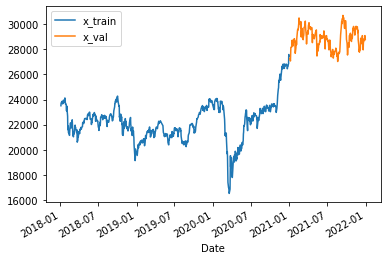

In [17]:
# 学習データと検証データの終値(Close)の折れ線グラフ作成
x_train['Close'].plot(kind='line')
x_val['Close'].plot(kind='line')

# グラフの凡例を設定
plt.legend(['x_train','x_val'])

# グラフの表示
plt.show()

### データを整える

説明変数は各週毎の7日間をセットとして一つにまとめる。  
目的変数は翌日の始値が上がるか下がるかを示すデータを抜き出す。

In [18]:
# 標準化関数(StandardScaler)のインポート
from sklearn.preprocessing import StandardScaler

import numpy as np

# 7日ごとにデータを抜き出して、標準化ととnumpy配列に変換する関数(std_to_np)の定義
def std_to_np(df):
    df_list=[]  #空のリストを定義(ここには標準化をおこなった後の、7日毎にまとまったデータを格納して行く)
    df=np.array(df)  #入力されたデータフレームをまずnumpy配列に変換
    for i in range(0,len(df)-xdays):  #array(df)配列に対して、for文を用いて7日ずつのデータ抜き出して、df_sに入力
                                    #range(start,stop,step)0からlen(df)=13967個のデータを7個ずつで区切って繰り返す。
        df_s=df[i:i+xdays]  #dfのindexを7日分取り出す。
        scl=StandardScaler()  #標準化
        
        #最後の7日分のデータまでこの繰り返し処理を行う。
        
        df_std=scl.fit_transform(df_s)  #標準化をおこなった結果をdf_stdに入力
        df_list.append(df_std)  #df_listをnumpy配列で出力(return np.array(df_list))
    return np.array(df_list)

In [22]:
# 学習データと検証データの説明変数に関数(std_to_np)を実行
x_train_np_array=std_to_np(x_train)
x_val_np_array=std_to_np(x_val)

# 学習データと検証データの形の確認
print(x_train_np_array.shape) #(データ数,7日分のデータ数で区切っている,説明変数のカラム数)
print(x_val_np_array.shape)

(722, 7, 8)
(238, 7, 8)


In [23]:
# 学習データと検証データの目的変数を確認
print(y_train)
print(y_val)

Date
2018-01-16    0
2018-01-17    0
2018-01-18    1
2018-01-19    1
2018-01-22    1
             ..
2020-12-24    0
2020-12-25    1
2020-12-28    1
2020-12-29    0
2020-12-30    0
Name: Up, Length: 722, dtype: int64
Date
2021-01-14    0
2021-01-15    0
2021-01-18    1
2021-01-19    0
2021-01-20    1
             ..
2021-12-24    0
2021-12-27    1
2021-12-28    0
2021-12-29    0
2021-12-30    0
Name: Up, Length: 238, dtype: int64


学習データは722個、検証データは238個あることがわかる

### 予測モデルの作成

In [25]:
#!pip install tensorflow

In [26]:
# keras.modelsからSequentialのインポート
from keras.models import Sequential

# keras.layersからDense、LSTMのインポート
from keras.layers import Dense,LSTM

# Dropoutのインポート
from keras.layers import Dropout

In [27]:
# LSTM構築とコンパイル関数
def lstm_comp(df):
    # 入力層/中間層/出力層のネットワークを構築
    model = Sequential()
    
    #隠れ層の数は256
    #活性化関数はrelu(:入力した値が0以下のとき0になり、1より大きいとき入力をそのまま出力)
    #batch_input_shapeは、1回に入力するデータ＝1行分のデータ、となる
    model.add(LSTM(256, activation='relu', batch_input_shape=(None, df.shape[1], df.shape[2])))
    
    #2割をドロップアウトする
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    
    #出力層
    #2値分類なのでシグモイド関数を用いる。
    model.add(Dense(1, activation='sigmoid'))  

    # モデルを作成する
    #loss:損失関数 , binary_crossentropy:2クラス分類時の交差エントロピー
    #optimizer:コンパイル時に最適化手法 , adam:移動平均で振動を抑制するモーメンタム と 学習率を調整して振動を抑制するRMSProp を組み合わせ
    #metrics:評価指標,accuracy:正解率(推定した値と真の値が一致した割合)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

交差検証今回はデータ量が多いので、工程を省く

#### モデルを用いた予測  
標準化した学習データでLSTMモデルを作成

In [28]:
# LSTM構築とコンパイル関数にX_train_np_arrayを渡し、変数modelに代入
model=lstm_comp(x_train_np_array)

In [29]:
# モデルの学習の実行
result=model.fit(x_train_np_array,y_train,epochs=10,batch_size=64)

Epoch 1/10
12/12 [==============================] - 2s 25ms/step - loss: 0.6945 - accuracy: 0.5083
Epoch 2/10
12/12 [==============================] - 0s 25ms/step - loss: 0.6928 - accuracy: 0.5028
Epoch 3/10
12/12 [==============================] - 0s 22ms/step - loss: 0.6935 - accuracy: 0.5332
Epoch 4/10
12/12 [==============================] - 0s 25ms/step - loss: 0.6908 - accuracy: 0.5208
Epoch 5/10
12/12 [==============================] - 0s 25ms/step - loss: 0.6896 - accuracy: 0.5305
Epoch 6/10
12/12 [==============================] - 0s 27ms/step - loss: 0.6880 - accuracy: 0.5388
Epoch 7/10
12/12 [==============================] - 0s 28ms/step - loss: 0.6861 - accuracy: 0.5319
Epoch 8/10
12/12 [==============================] - 0s 29ms/step - loss: 0.6853 - accuracy: 0.5471
Epoch 9/10
12/12 [==============================] - 0s 29ms/step - loss: 0.6937 - accuracy: 0.5111
Epoch 10/10
12/12 [==============================] - 0s 26ms/step - loss: 0.6856 - accuracy: 0.5485


In [30]:
# 作成したモデルより検証データを用いて予測を行う
pred=model.predict(x_val_np_array)
pred[:10]

8/8 [==============================] - 0s 10ms/step


array([[0.5542033 ],
       [0.55525774],
       [0.5360443 ],
       [0.49848554],
       [0.48832145],
       [0.48912033],
       [0.49072415],
       [0.47708297],
       [0.5055311 ],
       [0.5110794 ]], dtype=float32)

In [31]:
# 予測結果を0もしくは1に修正（0.5を境にして、1に近いほど株価が上昇、0に近いほど株価が上昇しない）
pred=np.where(pred<0.5,0,1)

# 修正した予測結果の先頭10件を確認
pred[:10]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1]])

In [32]:
# accuracy算出のためaccuracy_scoreのインポート
from sklearn.metrics import accuracy_score

# 実際の結果から予測値の正解率を計算する
print('accuracy=',accuracy_score(y_true=y_val,y_pred=pred))

accuracy= 0.5084033613445378


#### 混同行列を用いて結果を視覚化する

In [33]:
# 混同行列生成のためconfusion_matrixをインポート
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

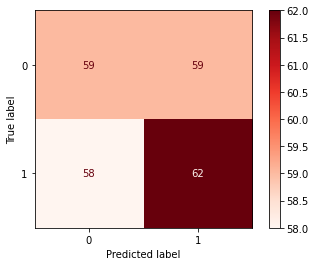

In [34]:
#混同行列を表示
cm=confusion_matrix(y_val,pred)
cmp=ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

## 結果  
精度はまずまず。

## 考察  
二値分類で精度0.5前後なのでまずまずの結果  
「特徴量追加」や「学習するサイクルを7日間から多くする」など検証してみる。

## 検証②  
区切る日にちを7日間から30日間にして学習してみる。

In [35]:
xdays = 30

# 学習データを説明変数(X_train)と目的変数(y_train)に分ける
x_train=df_train[['High', 'Low', 'Open', 'Close','Volume','Adj Close','Close_ratio', 'Body']]
y_train=df_train['Up'][xdays:]

# 学習データの説明変数と目的変数を確認
print(x_train)
print(y_train)

                    High           Low          Open         Close  \
Date                                                                 
2018-01-04  23506.330078  23065.199219  23073.730469  23506.330078   
2018-01-05  23730.470703  23520.519531  23643.000000  23714.529297   
2018-01-09  23952.609375  23789.029297  23948.970703  23849.990234   
2018-01-10  23864.759766  23755.449219  23832.810547  23788.199219   
2018-01-11  23734.970703  23601.839844  23656.390625  23710.429688   
...                  ...           ...           ...           ...   
2020-12-24  26764.529297  26605.259766  26635.109375  26668.349609   
2020-12-25  26716.609375  26638.279297  26708.099609  26656.609375   
2020-12-28  26854.029297  26664.599609  26691.289062  26854.029297   
2020-12-29  27602.519531  26921.140625  26936.380859  27568.150391   
2020-12-30  27572.570312  27338.560547  27559.099609  27444.169922   

                 Volume     Adj Close  Close_ratio        Body  
Date                    

In [36]:
# 検証データを説明変数(X_val)と目的変数(y_val)に分ける
x_val=df_val[['High', 'Low', 'Open', 'Close','Volume','Adj Close','Close_ratio', 'Body']]
y_val=df_val['Up'][xdays:]

# 検証データの説明変数と目的変数を確認
print(x_val)
print(y_val)

                    High           Low          Open         Close  \
Date                                                                 
2021-01-04  27602.109375  27042.320312  27575.570312  27258.380859   
2021-01-05  27279.779297  27073.460938  27151.380859  27158.630859   
2021-01-06  27196.400391  27002.179688  27102.849609  27055.939453   
2021-01-07  27624.730469  27340.460938  27340.460938  27490.130859   
2021-01-08  28139.029297  27667.750000  27720.140625  28139.029297   
...                  ...           ...           ...           ...   
2021-12-24  28870.130859  28773.500000  28836.050781  28782.589844   
2021-12-27  28805.279297  28658.820312  28786.330078  28676.460938   
2021-12-28  29121.009766  28879.679688  28953.320312  29069.160156   
2021-12-29  29106.279297  28729.609375  28995.730469  28906.880859   
2021-12-30  28904.419922  28579.490234  28794.240234  28791.710938   

                Volume     Adj Close  Close_ratio        Body  
Date                     

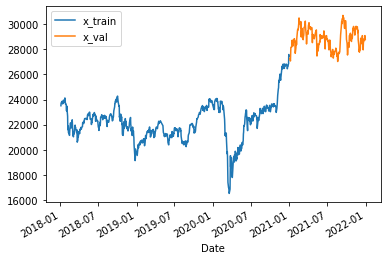

In [37]:
# 学習データと検証データの終値(Close)の折れ線グラフ作成
x_train['Close'].plot(kind='line')
x_val['Close'].plot(kind='line')

# グラフの凡例を設定
plt.legend(['x_train','x_val'])

# グラフの表示
plt.show()

### データを整える

説明変数は各週毎の7日間をセットとして一つにまとめる。  
目的変数は翌日の始値が上がるか下がるかを示すデータを抜き出す。

In [38]:
# 30日ごとにデータを抜き出して、標準化ととnumpy配列に変換する関数(std_to_np)の定義
def std_to_np(df):
    df_list=[]  #空のリストを定義(ここには標準化をおこなった後の、7日毎にまとまったデータを格納して行く)
    df=np.array(df)  #入力されたデータフレームをまずnumpy配列に変換
    for i in range(0,len(df)-xdays):  #array(df)配列に対して、for文を用いて7日ずつのデータ抜き出して、df_sに入力
                                    #range(start,stop,step)0からlen(df)=13967個のデータを7個ずつで区切って繰り返す。
        df_s=df[i:i+xdays]  #dfのindexを7日分取り出す。
        scl=StandardScaler()  #標準化
        
        #最後の7日分のデータまでこの繰り返し処理を行う。
        
        df_std=scl.fit_transform(df_s)  #標準化をおこなった結果をdf_stdに入力
        df_list.append(df_std)  #df_listをnumpy配列で出力(return np.array(df_list))
    return np.array(df_list)

In [42]:
# 学習データと検証データの説明変数に関数(std_to_np)を実行
x_train_np_array=std_to_np(x_train)
x_val_np_array=std_to_np(x_val)

# 学習データと検証データの形の確認
print(x_train_np_array.shape) #(データ数,7日分のデータ数で区切っている,説明変数のカラム数)
print(x_val_np_array.shape)

(699, 30, 8)
(215, 30, 8)


In [43]:
# 学習データと検証データの目的変数を確認
print(y_train)
print(y_val)

Date
2018-02-19    0
2018-02-20    1
2018-02-21    0
2018-02-22    1
2018-02-23    1
             ..
2020-12-24    0
2020-12-25    1
2020-12-28    1
2020-12-29    0
2020-12-30    0
Name: Up, Length: 699, dtype: int64
Date
2021-02-17    0
2021-02-18    0
2021-02-19    1
2021-02-22    0
2021-02-24    1
             ..
2021-12-24    0
2021-12-27    1
2021-12-28    0
2021-12-29    0
2021-12-30    0
Name: Up, Length: 215, dtype: int64


学習データは699個、検証データは215個あることがわかる

### 予測モデルの作成

In [47]:
# LSTM構築とコンパイル関数
def lstm_comp(df):
    # 入力層/中間層/出力層のネットワークを構築
    model = Sequential()
    
    #隠れ層の数は256
    #活性化関数はrelu(:入力した値が0以下のとき0になり、1より大きいとき入力をそのまま出力)
    #batch_input_shapeは、1回に入力するデータ＝1行分のデータ、となる
    model.add(LSTM(256, activation='relu', batch_input_shape=(None, df.shape[1], df.shape[2])))
    
    #2割をドロップアウトする
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    
    #出力層
    #2値分類なのでシグモイド関数を用いる。
    model.add(Dense(1, activation='sigmoid'))  

    # モデルを作成する
    #loss:損失関数 , binary_crossentropy:2クラス分類時の交差エントロピー
    #optimizer:コンパイル時に最適化手法 , adam:移動平均で振動を抑制するモーメンタム と 学習率を調整して振動を抑制するRMSProp を組み合わせ
    #metrics:評価指標,accuracy:正解率(推定した値と真の値が一致した割合)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

#### モデルを用いた予測  
標準化した学習データでLSTMモデルを作成

In [48]:
# LSTM構築とコンパイル関数にX_train_np_arrayを渡し、変数modelに代入
model=lstm_comp(x_train_np_array)

In [49]:
# モデルの学習の実行
result=model.fit(x_train_np_array,y_train,epochs=10,batch_size=64)

Epoch 1/10
11/11 [==============================] - 3s 114ms/step - loss: 0.6939 - accuracy: 0.5236
Epoch 2/10
11/11 [==============================] - 1s 90ms/step - loss: 0.6909 - accuracy: 0.5179
Epoch 3/10
11/11 [==============================] - 1s 89ms/step - loss: 0.6875 - accuracy: 0.5308
Epoch 4/10
11/11 [==============================] - 1s 89ms/step - loss: 0.6867 - accuracy: 0.5465
Epoch 5/10
11/11 [==============================] - 1s 100ms/step - loss: 0.6842 - accuracy: 0.5422
Epoch 6/10
11/11 [==============================] - 1s 121ms/step - loss: 0.6819 - accuracy: 0.5465
Epoch 7/10
11/11 [==============================] - 1s 122ms/step - loss: 0.6810 - accuracy: 0.5436
Epoch 8/10
11/11 [==============================] - 1s 119ms/step - loss: 0.6846 - accuracy: 0.5336
Epoch 9/10
11/11 [==============================] - 1s 120ms/step - loss: 0.6780 - accuracy: 0.5565
Epoch 10/10
11/11 [==============================] - 1s 98ms/step - loss: 0.6753 - accuracy: 0.5937


In [50]:
# 作成したモデルより検証データを用いて予測を行う
pred=model.predict(x_val_np_array)
pred[:10]

7/7 [==============================] - 0s 29ms/step


array([[0.592364  ],
       [0.54534245],
       [0.51180893],
       [0.4604563 ],
       [0.4669627 ],
       [0.41480836],
       [0.5093575 ],
       [0.4055553 ],
       [0.43924427],
       [0.41045195]], dtype=float32)

In [51]:
# 予測結果を0もしくは1に修正（0.5を境にして、1に近いほど株価が上昇、0に近いほど株価が上昇しない）
pred=np.where(pred<0.5,0,1)

# 修正した予測結果の先頭10件を確認
pred[:10]

array([[1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])

In [52]:
# 実際の結果から予測値の正解率を計算する
print('accuracy=',accuracy_score(y_true=y_val,y_pred=pred))

accuracy= 0.5395348837209303


#### 混同行列を用いて結果を視覚化する

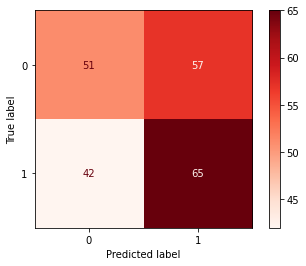

In [54]:
#混同行列を表示
cm=confusion_matrix(y_val,pred)
cmp=ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

## 結果  
7日間で区切るより、30日間で区切る方が精度が上がる。

## 検証③  
30日間で区切ったうえで、特徴量を追加してみる。

## 特徴量の追加  
*  終値の前日比率  
*  始値・終値の差分

In [55]:
df

,High,Low,Open,Close,Volume,Adj Close,Close_ratio,Body,Up
Date,,,,,,,,,
2018-01-04,23506.330078,23065.199219,23073.730469,23506.330078,102200000.0,23506.330078,-0.008779,-432.599609,1
2018-01-05,23730.470703,23520.519531,23643.000000,23714.529297,101900000.0,23714.529297,-0.005680,-71.529297,1
2018-01-09,23952.609375,23789.029297,23948.970703,23849.990234,94100000.0,23849.990234,0.002598,98.980469,0
2018-01-10,23864.759766,23755.449219,23832.810547,23788.199219,88800000.0,23788.199219,0.003280,44.611328,0
2018-01-11,23734.970703,23601.839844,23656.390625,23710.429688,83700000.0,23710.429688,0.002393,-54.039062,0
...,...,...,...,...,...,...,...,...,...
2021-12-24,28870.130859,28773.500000,28836.050781,28782.589844,35900000.0,28782.589844,0.003701,53.460938,0
2021-12-27,28805.279297,28658.820312,28786.330078,28676.460938,37500000.0,28676.460938,-0.013509,109.869141,1
2021-12-28,29121.009766,28879.679688,28953.320312,29069.160156,47000000.0,29069.160156,0.005614,-115.839844,0


In [56]:
df_technical=df.copy()

In [57]:
#移動平均の追加(特徴量)
sma1=5
sma2=10
sma3=15

df_technical['sma1']=df_technical['Close'].rolling(sma1).mean()
df_technical['sma2']=df_technical['Close'].rolling(sma2).mean()
df_technical['sma3']=df_technical['Close'].rolling(sma3).mean()


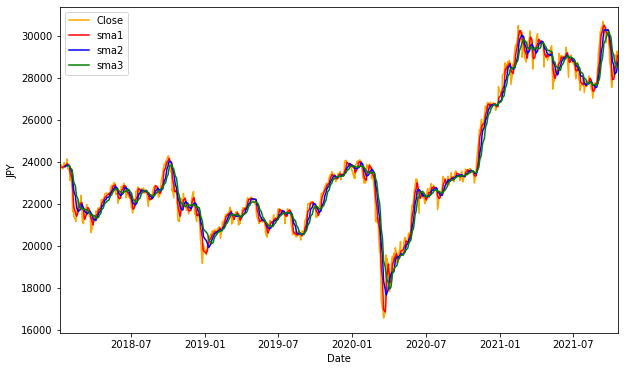

In [58]:
plt.figure(figsize=(10,6))

plt.plot(df_technical['Close'],label='Close',color='orange')
plt.plot(df_technical['sma1'],label='sma1',color='red')
plt.plot(df_technical['sma2'],label='sma2',color='blue')
plt.plot(df_technical['sma3'],label='sma3',color='green')
plt.xlabel('Date')
plt.ylabel('JPY')
plt.legend()
xmin=datetime(2018,1,5)
xmax=datetime(2021,10,21)
plt.xlim([xmin,xmax])
plt.show()

In [59]:
df_technical.head()

,High,Low,Open,Close,Volume,Adj Close,Close_ratio,Body,Up,sma1,sma2,sma3
Date,,,,,,,,,,,,
2018-01-04,23506.330078,23065.199219,23073.730469,23506.330078,102200000.0,23506.330078,-0.008779,-432.599609,1,NaN,NaN,NaN
2018-01-05,23730.470703,23520.519531,23643.000000,23714.529297,101900000.0,23714.529297,-0.005680,-71.529297,1,NaN,NaN,NaN
2018-01-09,23952.609375,23789.029297,23948.970703,23849.990234,94100000.0,23849.990234,0.002598,98.980469,0,NaN,NaN,NaN
2018-01-10,23864.759766,23755.449219,23832.810547,23788.199219,88800000.0,23788.199219,0.003280,44.611328,0,NaN,NaN,NaN
2018-01-11,23734.970703,23601.839844,23656.390625,23710.429688,83700000.0,23710.429688,0.002393,-54.039062,0,23713.895703,NaN,NaN


In [60]:
#欠損値を含む日を削除する。
df_technical=df_technical.dropna(how='any')
df_technical.head()

,High,Low,Open,Close,Volume,Adj Close,Close_ratio,Body,Up,sma1,sma2,sma3
Date,,,,,,,,,,,,
2018-01-25,23828.400391,23649.029297,23750.650391,23669.490234,81500000.0,23669.490234,0.001591,81.160156,0,23871.762109,23831.103125,23792.033984
2018-01-26,23797.960938,23592.279297,23757.339844,23631.880859,87200000.0,23631.880859,0.000108,125.458984,0,23836.526172,23828.909180,23800.404036
2018-01-29,23787.230469,23580.169922,23707.140625,23629.339844,68800000.0,23629.339844,0.014484,77.800781,0,23799.128125,23820.355078,23794.724740
2018-01-30,23581.980469,23233.369141,23559.330078,23291.970703,88800000.0,23291.970703,0.008385,267.359375,0,23632.692188,23754.371094,23757.523438
2018-01-31,23375.380859,23092.849609,23205.230469,23098.289062,99800000.0,23098.289062,-0.016513,106.941406,1,23464.194141,23677.366016,23711.529427


新たに移動平均を加えたデータでモデルを作成する。

In [61]:
df_train=df_technical['2018-01-05':'2020-12-31']
df_train.tail()

,High,Low,Open,Close,Volume,Adj Close,Close_ratio,Body,Up,sma1,sma2,sma3
Date,,,,,,,,,,,,
2020-12-24,26764.529297,26605.259766,26635.109375,26668.349609,47900000.0,26668.349609,0.000440,-33.240234,0,26621.467969,26674.420898,26672.276562
2020-12-25,26716.609375,26638.279297,26708.099609,26656.609375,33400000.0,26656.609375,-0.007352,51.490234,1,26600.111719,26674.829883,26665.967839
2020-12-28,26854.029297,26664.599609,26691.289062,26854.029297,50700000.0,26854.029297,-0.025904,-162.740234,1,26628.033594,26686.988867,26686.407161
2020-12-29,27602.519531,26921.140625,26936.380859,27568.150391,59400000.0,27568.150391,0.004518,-631.769531,0,26854.385547,26775.019922,26759.811849
2020-12-30,27572.570312,27338.560547,27559.099609,27444.169922,50600000.0,27444.169922,0.006816,114.929688,0,27038.261719,26843.696875,26801.560547


In [62]:
df_val=df_technical['2021-01-01':]
df_val.tail()

,High,Low,Open,Close,Volume,Adj Close,Close_ratio,Body,Up,sma1,sma2,sma3
Date,,,,,,,,,,,,
2021-12-23,28798.369141,28640.150391,28703.009766,28798.369141,43600000.0,28798.369141,0.000548,-95.359375,0,28472.332031,28539.860156,28493.148698
2021-12-24,28870.130859,28773.500000,28836.050781,28782.589844,35900000.0,28782.589844,0.003701,53.460938,0,28519.714062,28574.342187,28543.350000
2021-12-27,28805.279297,28658.820312,28786.330078,28676.460938,37500000.0,28676.460938,-0.013509,109.869141,1,28667.444141,28577.939258,28593.289453
2021-12-28,29121.009766,28879.679688,28953.320312,29069.160156,47000000.0,29069.160156,0.005614,-115.839844,0,28777.758203,28641.591211,28634.193490
2021-12-29,29106.279297,28729.609375,28995.730469,28906.880859,44700000.0,28906.880859,0.004000,88.849609,0,28846.692188,28686.307227,28637.277604


In [63]:
x_train=df_train[['High','Low','Open','Close','Close_ratio','Body','sma1','sma2','sma3']]
y_train=df_train['Up']

In [64]:
x_val=df_val[['High','Low','Open','Close','Close_ratio','Body','sma1','sma2','sma3']]
y_val=df_val['Up']

print(x_val)
#print(y_val)

                    High           Low          Open         Close  \
Date                                                                 
2021-01-04  27602.109375  27042.320312  27575.570312  27258.380859   
2021-01-05  27279.779297  27073.460938  27151.380859  27158.630859   
2021-01-06  27196.400391  27002.179688  27102.849609  27055.939453   
2021-01-07  27624.730469  27340.460938  27340.460938  27490.130859   
2021-01-08  28139.029297  27667.750000  27720.140625  28139.029297   
...                  ...           ...           ...           ...   
2021-12-23  28798.369141  28640.150391  28703.009766  28798.369141   
2021-12-24  28870.130859  28773.500000  28836.050781  28782.589844   
2021-12-27  28805.279297  28658.820312  28786.330078  28676.460938   
2021-12-28  29121.009766  28879.679688  28953.320312  29069.160156   
2021-12-29  29106.279297  28729.609375  28995.730469  28906.880859   

            Close_ratio        Body          sma1          sma2          sma3  
Date     

In [65]:
xdays = 30

# 学習データを説明変数(X_train)と目的変数(y_train)に分ける
x_train=df_train[['High','Low','Open','Close','Close_ratio','Body','sma1','sma2','sma3']]
y_train=df_train['Up'][xdays:]

# 学習データの説明変数と目的変数を確認
print(x_train)
print(y_train)

                    High           Low          Open         Close  \
Date                                                                 
2018-01-25  23828.400391  23649.029297  23750.650391  23669.490234   
2018-01-26  23797.960938  23592.279297  23757.339844  23631.880859   
2018-01-29  23787.230469  23580.169922  23707.140625  23629.339844   
2018-01-30  23581.980469  23233.369141  23559.330078  23291.970703   
2018-01-31  23375.380859  23092.849609  23205.230469  23098.289062   
...                  ...           ...           ...           ...   
2020-12-24  26764.529297  26605.259766  26635.109375  26668.349609   
2020-12-25  26716.609375  26638.279297  26708.099609  26656.609375   
2020-12-28  26854.029297  26664.599609  26691.289062  26854.029297   
2020-12-29  27602.519531  26921.140625  26936.380859  27568.150391   
2020-12-30  27572.570312  27338.560547  27559.099609  27444.169922   

            Close_ratio        Body          sma1          sma2          sma3  
Date     

In [66]:
# 検証データを説明変数(X_val)と目的変数(y_val)に分ける
x_val=df_val[['High','Low','Open','Close','Close_ratio','Body','sma1','sma2','sma3']]
y_val=df_val['Up'][xdays:]

# 検証データの説明変数と目的変数を確認
print(x_val)
print(y_val)

                    High           Low          Open         Close  \
Date                                                                 
2021-01-04  27602.109375  27042.320312  27575.570312  27258.380859   
2021-01-05  27279.779297  27073.460938  27151.380859  27158.630859   
2021-01-06  27196.400391  27002.179688  27102.849609  27055.939453   
2021-01-07  27624.730469  27340.460938  27340.460938  27490.130859   
2021-01-08  28139.029297  27667.750000  27720.140625  28139.029297   
...                  ...           ...           ...           ...   
2021-12-23  28798.369141  28640.150391  28703.009766  28798.369141   
2021-12-24  28870.130859  28773.500000  28836.050781  28782.589844   
2021-12-27  28805.279297  28658.820312  28786.330078  28676.460938   
2021-12-28  29121.009766  28879.679688  28953.320312  29069.160156   
2021-12-29  29106.279297  28729.609375  28995.730469  28906.880859   

            Close_ratio        Body          sma1          sma2          sma3  
Date     

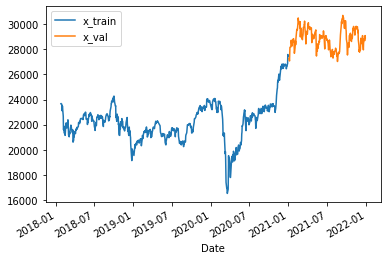

In [67]:
# 学習データと検証データの終値(Close)の折れ線グラフ作成
x_train['Close'].plot(kind='line')
x_val['Close'].plot(kind='line')

# グラフの凡例を設定
plt.legend(['x_train','x_val'])

# グラフの表示
plt.show()

### データを整える

説明変数は各週毎の7日間をセットとして一つにまとめる。  
目的変数は翌日の始値が上がるか下がるかを示すデータを抜き出す。

In [68]:
# 7日ごとにデータを抜き出して、標準化ととnumpy配列に変換する関数(std_to_np)の定義
def std_to_np(df):
    df_list=[]  #空のリストを定義(ここには標準化をおこなった後の、7日毎にまとまったデータを格納して行く)
    df=np.array(df)  #入力されたデータフレームをまずnumpy配列に変換
    for i in range(0,len(df)-xdays):  #array(df)配列に対して、for文を用いて7日ずつのデータ抜き出して、df_sに入力
                                    #range(start,stop,step)0からlen(df)=13967個のデータを7個ずつで区切って繰り返す。
        df_s=df[i:i+xdays]  #dfのindexを7日分取り出す。
        scl=StandardScaler()  #標準化
        
        #最後の7日分のデータまでこの繰り返し処理を行う。
        
        df_std=scl.fit_transform(df_s)  #標準化をおこなった結果をdf_stdに入力
        df_list.append(df_std)  #df_listをnumpy配列で出力(return np.array(df_list))
    return np.array(df_list)

In [72]:
# 学習データと検証データの説明変数に関数(std_to_np)を実行
x_train_np_array=std_to_np(x_train)
x_val_np_array=std_to_np(x_val)

# 学習データと検証データの形の確認
print(x_train_np_array.shape) #(データ数,7日分のデータ数で区切っている,説明変数のカラム数)
print(x_val_np_array.shape)

(685, 30, 9)
(214, 30, 9)


In [73]:
# 学習データと検証データの目的変数を確認
print(y_train)
print(y_val)

Date
2018-03-09    1
2018-03-12    1
2018-03-13    0
2018-03-14    1
2018-03-15    0
             ..
2020-12-24    0
2020-12-25    1
2020-12-28    1
2020-12-29    0
2020-12-30    0
Name: Up, Length: 685, dtype: int64
Date
2021-02-17    0
2021-02-18    0
2021-02-19    1
2021-02-22    0
2021-02-24    1
             ..
2021-12-23    0
2021-12-24    0
2021-12-27    1
2021-12-28    0
2021-12-29    0
Name: Up, Length: 214, dtype: int64


### 予測モデルの作成

In [77]:
# LSTM構築とコンパイル関数
def lstm_comp(df):
    # 入力層/中間層/出力層のネットワークを構築
    model = Sequential()
    
    #隠れ層の数は256
    #活性化関数はrelu(:入力した値が0以下のとき0になり、1より大きいとき入力をそのまま出力)
    #batch_input_shapeは、1回に入力するデータ＝1行分のデータ、となる
    model.add(LSTM(256, activation='relu', batch_input_shape=(None, df.shape[1], df.shape[2])))
    
    #2割をドロップアウトする
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    
    #出力層
    #2値分類なのでシグモイド関数を用いる。
    model.add(Dense(1, activation='sigmoid'))  

    # モデルを作成する
    #loss:損失関数 , binary_crossentropy:2クラス分類時の交差エントロピー
    #optimizer:コンパイル時に最適化手法 , adam:移動平均で振動を抑制するモーメンタム と 学習率を調整して振動を抑制するRMSProp を組み合わせ
    #metrics:評価指標,accuracy:正解率(推定した値と真の値が一致した割合)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

交差検証今回はデータ量が多いので、工程を省く

#### モデルを用いた予測  
標準化した学習データでLSTMモデルを作成

In [78]:
# LSTM構築とコンパイル関数にX_train_np_arrayを渡し、変数modelに代入
model=lstm_comp(x_train_np_array)

In [79]:
# モデルの学習の実行
result=model.fit(x_train_np_array,y_train,epochs=10,batch_size=64)

Epoch 1/10
11/11 [==============================] - 3s 110ms/step - loss: 0.6956 - accuracy: 0.5270
Epoch 2/10
11/11 [==============================] - 1s 124ms/step - loss: 0.6931 - accuracy: 0.5036
Epoch 3/10
11/11 [==============================] - 1s 133ms/step - loss: 0.6897 - accuracy: 0.5314
Epoch 4/10
11/11 [==============================] - 1s 120ms/step - loss: 0.6860 - accuracy: 0.5299
Epoch 5/10
11/11 [==============================] - 1s 103ms/step - loss: 0.6831 - accuracy: 0.5591
Epoch 6/10
11/11 [==============================] - 1s 105ms/step - loss: 0.6852 - accuracy: 0.5445
Epoch 7/10
11/11 [==============================] - 1s 123ms/step - loss: 0.6866 - accuracy: 0.5285
Epoch 8/10
11/11 [==============================] - 2s 143ms/step - loss: 0.6830 - accuracy: 0.5431
Epoch 9/10
11/11 [==============================] - 2s 141ms/step - loss: 0.6838 - accuracy: 0.5591
Epoch 10/10
11/11 [==============================] - 1s 134ms/step - loss: 0.6793 - accuracy: 0.5562

In [80]:
# 作成したモデルより検証データを用いて予測を行う
pred=model.predict(x_val_np_array)
pred[:10]

7/7 [==============================] - 1s 42ms/step


array([[0.6655295 ],
       [0.6432929 ],
       [0.61761504],
       [0.5855609 ],
       [0.572556  ],
       [0.5028982 ],
       [0.5503781 ],
       [0.4456791 ],
       [0.4773323 ],
       [0.45718408]], dtype=float32)

In [81]:
# 予測結果を0もしくは1に修正（0.5を境にして、1に近いほど株価が上昇、0に近いほど株価が上昇しない）
pred=np.where(pred<0.5,0,1)

# 修正した予測結果の先頭10件を確認
pred[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0]])

In [82]:
# 実際の結果から予測値の正解率を計算する
print('accuracy=',accuracy_score(y_true=y_val,y_pred=pred))

accuracy= 0.5327102803738317


#### 混同行列を用いて結果を視覚化する

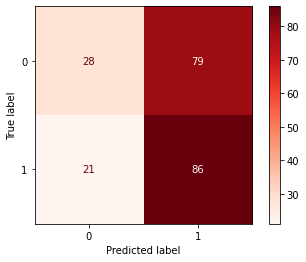

In [84]:
#混同行列を表示
cm=confusion_matrix(y_val,pred)
cmp=ConfusionMatrixDisplay(cm)
cmp.plot(cmap=plt.cm.Reds)

### 結果とまとめ  
幾分か実行を繰り返してみたが、抽出期間を大きくして特徴量を増やすと数%精度が良くなった。  
やはり、株価は人間の感情で上下しているという点や、政治や情勢など予測不可能な多くの要因があり精度を上げるのは至難と言える。  
精度を上げる方法としては、社会情勢なども予想していく必要があると考えられる。